In [48]:
import warnings
#warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

# from io import StringIO
from pandas.compat import StringIO

import pysam
from pysam import TabixFile


## Apply some basic thresholding to filter outliers

In [9]:
df = pd.read_csv('./HG00096.regions.bed', sep='\t', 
                 names=['chr', 'start', 'end', 'region_mean'], 
                 dtype={'chr': str})

threshold = 2*df['region_mean'].std()
mean = df['region_mean'].std()

# Definitely want to filter out low mean depth regions, but not sure about 
# filtering out high depth regions...
df = df[(df['region_mean'] > 10) & 
        (df['region_mean'] < mean + threshold)]
print(len(df))
df.head()

117406


,chr,start,end,region_mean
1,1,861271,861443,23.35
3,1,866368,866519,18.74
4,1,871102,871326,29.63
6,1,874605,874890,14.15
10,1,878583,878807,13.77


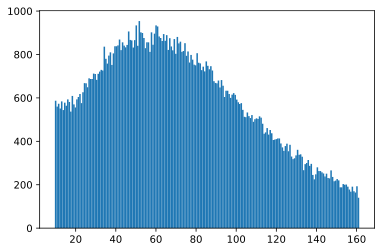

In [10]:
plt.hist(df['region_mean'],bins=200, align='left');

## Mess around with pysam
This library's documentation is not the best...

In [4]:
tbx = TabixFile('./HG00096.per-base.bed.gz', index='./HG00096.per-base.bed.gz.csi')

### Iterate over a Tabix query

In [5]:
out = StringIO()
query = tbx.fetch('1', 861271, 861443, parser=pysam.asTuple())
for row in query:
    out.write(str(row))
    out.write('\n')
    
# go back to the beginning of the file before reading from the stream
out.seek(0)
tb = pd.read_csv(out, sep='\t', names=['chr', 'start', 'end', 'depth'])
start = tb.iloc[0]['start']
end = tb.iloc[-1]['end']
tb.head()



,chr,start,end,depth
0,1,861270,861272,19
1,1,861272,861276,20
2,1,861276,861278,19
3,1,861278,861279,20
4,1,861279,861281,22


In [42]:
def extract_signals(x):
    """
    get the per-base signal from a region x
    """
    
    # get tabix output for region
    tbx.fetch()
    out = StringIO()
    query = tbx.fetch(x.chr, x.start, x.end)
    for row in query:
        out.write(str(row))
        out.write('\n')
    out.seek(0)
    tb = pd.read_csv(out, sep='\t', names=['chr', 'start', 'end', 'depth'])
    
    # replace region start end with the beginning/end of the tabix output
    #x['start'] = tb.iloc[0]['start']
    #x['end'] = tb.iloc[-1]['end']
    
    # get the signals
    return tb.apply(lambda x: (x.end - x.start) * '{},'.format(x.depth), axis=1).str.cat(sep=None)

%timeit -n 1 -r 1 df['signals'] = df.apply(extract_signals, axis=1)    

15min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
df.head()

,chr,start,end,region_mean,signals
1,1,861271,861443,23.35,"19,19,20,20,20,20,19,19,20,22,22,23,23,23,23,2..."
3,1,866368,866519,18.74,"20,20,20,20,20,21,21,21,21,21,21,21,22,22,23,2..."
4,1,871102,871326,29.63,"32,32,32,32,32,33,33,32,34,33,34,34,36,36,36,3..."
6,1,874605,874890,14.15,"9,9,9,9,9,9,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,8,..."
10,1,878583,878807,13.77,"12,12,12,12,12,12,11,13,12,12,12,12,12,11,11,1..."


## Alternative way
Return a tuple and expand the results into a dataframe.  This allows us to get the actual start and end of the tabix query result.

In [80]:
def extract_signals(x):
    """
    get the per-base signal from a region x
    """
    
    # get tabix output for region
    tbx.fetch()
    out = StringIO()
    query = tbx.fetch(x.chr, x.start, x.end)
    for row in query:
        out.write(str(row))
        out.write('\n')
    out.seek(0)
    tb = pd.read_csv(out, sep='\t', names=['chr', 'start', 'end', 'depth'])
    
    #replace region start end with the beginning/end of the tabix output
    region_start = tb.iloc[0]['start']
    region_end = tb.iloc[-1]['end']
    
    # get the signals
    return (x.chr, 
            region_start, 
            region_end, 
            tb.apply(lambda x: (x.end - x.start) * '{},'.format(x.depth), axis=1).str.cat(sep=None))

%timeit -n 1 -r 1 new_df = df.apply(extract_signals, axis=1, result_type='expand')
new_df.head()

16min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


,0,1,2,3
1,1,861270,861445,"19,19,20,20,20,20,19,19,20,22,22,23,23,23,23,2..."
3,1,866364,866526,"20,20,20,20,20,21,21,21,21,21,21,21,22,22,23,2..."
4,1,871099,871348,"32,32,32,32,32,33,33,32,34,33,34,34,36,36,36,3..."
6,1,874600,874893,"9,9,9,9,9,9,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,8,..."
10,1,878582,878808,"12,12,12,12,12,12,11,13,12,12,12,12,12,11,11,1..."


<IPython.core.display.Javascript object>


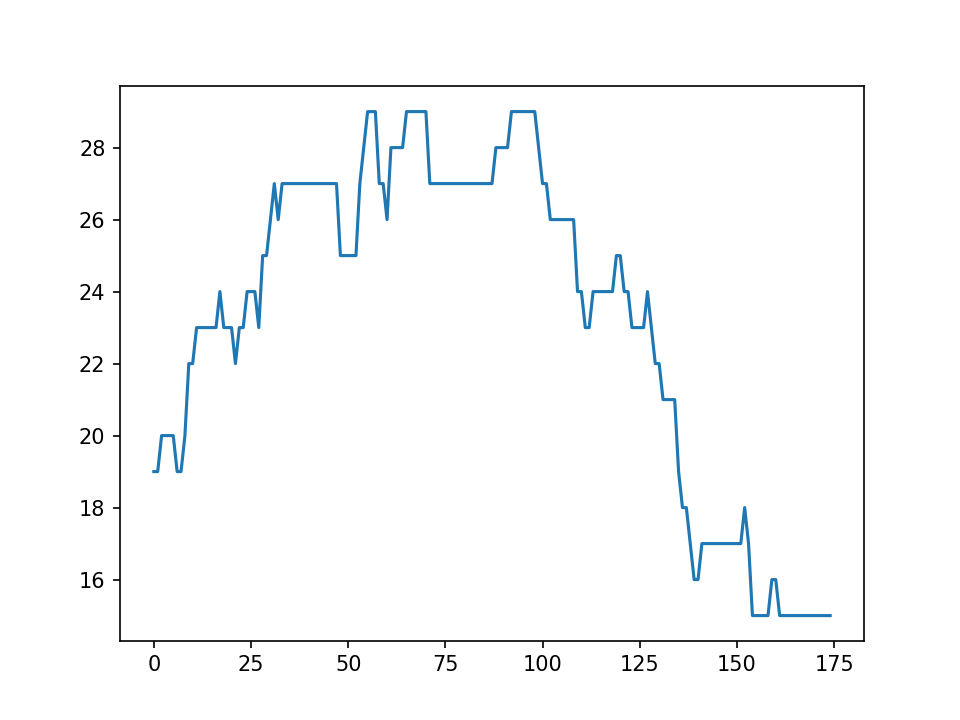

In [77]:
sig = np.fromstring(new_df.iloc[0][3], sep=',')
plt.plot(range(len(sig)), sig)